In [1]:
import os, sys, importlib

user = "MarcoC1796"
repo = "recommender-systems-thesis"
src_dir = "src"

if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git

path = f"{repo}"
if not path in sys.path:
    sys.path.append(path)

# list all directories in the Python path
print("\n".join(["'" + path + "'" for path in sys.path]))

Cloning into 'recommender-systems-thesis'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 111 (delta 0), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (111/111), 96.61 MiB | 6.78 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Updating files: 100% (23/23), done.
'/content'
'/env/python'
'/usr/lib/python310.zip'
'/usr/lib/python3.10'
'/usr/lib/python3.10/lib-dynload'
''
'/usr/local/lib/python3.10/dist-packages'
'/usr/lib/python3/dist-packages'
'/usr/local/lib/python3.10/dist-packages/IPython/extensions'
'/root/.ipython'
'recommender-systems-thesis'


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

plt.style.use("ggplot")

from src.alternatingLeastSquares import ALS
from src.gradientDescent import gradientDescent
from src.cost_functions import get_Jsim_and_DJsim

from src.aux_functions import initializeQ, initializeP

from src.plottingFunctions import plotALSResults

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
path = ""
path = "/content/drive/MyDrive/Thesis/Data/"
path += "ml-1m/ratings.dat"

rnames = ["user_id", "movie_id", "rating", "timestamp"]
movies = pd.read_table(path, sep="::", header=None, names=rnames, engine="python")
print(movies.shape)
movies = movies.drop('timestamp', axis=1)


movies_im = pd.pivot_table(movies, values="rating", index="user_id", columns="movie_id")
movies_im.reset_index(drop=True, inplace=True)
movies_im.columns = range(movies_im.shape[1])
print(movies_im.shape)
movies_im.head()


(1000209, 4)
(6040, 3706)


,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Use the melt function to transform the dataframe
movies_tr = pd.melt(movies_im.reset_index(), id_vars=['index'], var_name='movie_id', value_name='rating')

# Rename the columns
movies_tr.columns = ['user_id', 'movie_id', 'rating']


,user_id,movie_id,rating
0,0,0,5.0
1,1,0,NaN
2,2,0,NaN
3,3,0,NaN
4,4,0,NaN


In [41]:
movies_tr.shape

(22384240, 3)

In [25]:
R = movies_im.to_numpy()
print(f"{round((np.count_nonzero(~np.isnan(R))/R.size)*100, 2)}% of full entries")
print(R.shape)

4.47% of full entries
(6040, 3706)


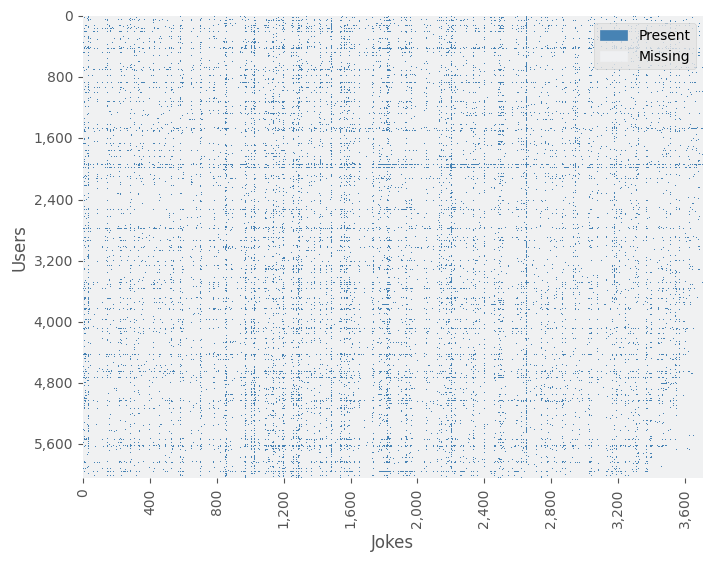

In [ ]:
# Create DataFrame with some missing values
df = movies_im
# Create a boolean mask for missing values
missing = df.notna()

# Create colormap
cmap = sns.light_palette("steelblue", as_cmap=True)

# Set figure size
plt.figure(figsize=(8, 6))  # width, height in inches

# Use Seaborn to visualize missingness
sns.heatmap(missing, cbar=False, cmap=cmap)

# Create legend
missing_patch = mpatches.Patch(color=cmap(0.99), label="Present")
not_missing_patch = mpatches.Patch(color=cmap(1), label="Missing")
plt.legend(handles=[missing_patch, not_missing_patch], loc="upper right")

# Add labels
plt.xlabel("Jokes")
plt.ylabel("Users")

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x))
plt.gca().yaxis.set_major_formatter(formatter)

# Limit the number of ticks on the y-axis
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(10))
plt.gca().yaxis.set_major_formatter(formatter)

# Limit the number of ticks on the x-axis
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

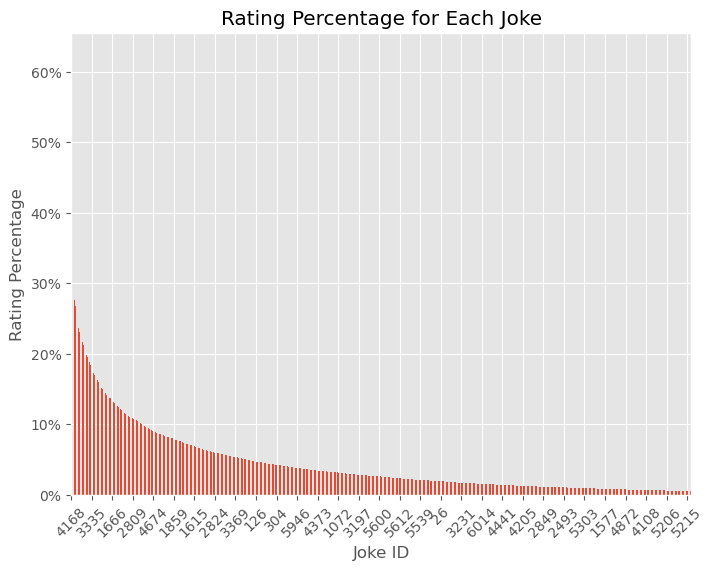

In [ ]:
df = pd.DataFrame(R)
rating_percentage = df.count(axis=1) / len(df.columns)

# Sort jokes by rating percentage in descending order
rating_percentage_sorted = rating_percentage.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
rating_percentage_sorted.plot(kind="bar")
plt.ylabel("Rating Percentage")
plt.xlabel("Joke ID")
plt.title("Rating Percentage for Each Joke")

# Modify x-ticks
n = 200  # Show every nth x-tick, adjust as needed
plt.xticks(
    range(0, len(rating_percentage_sorted), n),
    rating_percentage_sorted.index[::n],
    rotation=45,
)  # Rotate labels for better readability

# Modify y-ticks to show percentage
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))

plt.show()

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split

def train_test_split_interactions(interactions, random_state = 43):

  # Create a binary mask with the same shape as your interaction matrix, excluding missing values
  mask = ~np.isnan(interactions)

  # Get the indices of the cells where there's a non-missing interaction
  interaction_indices = np.transpose(np.nonzero(mask))

  # Split the indices into training and testing sets
  train_indices, test_indices = train_test_split(interaction_indices, test_size=0.2, random_state=random_state)

  # Create empty matrices for train and test interactions
  train_interactions = np.full(interactions.shape, np.nan)
  test_interactions = np.full(interactions.shape, np.nan)

  # Assign training interactions
  for row, col in train_indices:
      train_interactions[row, col] = interactions[row, col]

  # Assign testing interactions
  for row, col in test_indices:
      test_interactions[row, col] = interactions[row, col]

  return train_interactions, test_interactions


In [41]:
R_train_val, R_test = train_test_split_interactions(R)

In [42]:
mean_train_val = np.nanmean(R_train_val)
std_train_val = np.nanstd(R_train_val)
print(f"Global mean of matrix R: {mean_train_val}")
print(f" Global standard deviation of matrix R: {std_train_val}")
R_train_val_norm = (R_train_val - mean_train_val) / std_train_val

# Seed
np.random.seed(43)

f = 50
tol = 1e-5
max_iter = 1000

Jsim, DJsim = get_Jsim_and_DJsim(R_train_val_norm, f)

# Q and P initilization
Q = initializeQ(R.shape[0], f)
P = initializeP(R.shape[1], f)

Theta = np.concatenate((Q.flatten(), P.flatten()))

gradientDescentResults = gradientDescent(
    Jsim, Theta, DJsim, tol, max_iter, alpha0=0.0001
)
newThetas = gradientDescentResults["x_values"]
J_values = gradientDescentResults["func_values"]
newQs = gradientDescentResults["x_values"]

Global mean of matrix R: 3.5821922173746232
 Global standard deviation of matrix R: 1.1170484497129594
Iteration    0: Cost 16584802.54   
Iteration  100: Cost 647097.90   
Iteration  200: Cost 406610.31   
Iteration  300: Cost 331774.91   
Iteration  400: Cost 293568.64   
Iteration  500: Cost 269550.08   
Iteration  600: Cost 252547.64   
Iteration  700: Cost 239745.85   
Iteration  800: Cost 229768.32   
Iteration  900: Cost 221804.02   
Iteration  999: Cost 215378.29   


In [24]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame with 'user_id', 'movie_id' and 'rating' columns
df = movies

# Create an ID mapping for users and movies to convert their IDs into integer indices
user_id_mapping = {id:i for i, id in enumerate(df['user_id'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df['movie_id'].unique())}

# Apply the mapping to the user_id and movie_id columns
df['user_id'] = df['user_id'].map(user_id_mapping)
df['movie_id'] = df['movie_id'].map(movie_id_mapping)

# Split the DataFrame into training+validation and testing sets
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert the training+validation and testing DataFrames into sparse CSR matrices
R_train_val = csr_matrix((train_val_df['rating'], (train_val_df['user_id'], train_val_df['movie_id'])))
R_test = csr_matrix((test_df['rating'], (test_df['user_id'], test_df['movie_id'])), shape=R_train_val.shape)




In [30]:
R_test.count_nonzero() + R_train_val.count_nonzero() == np.count_nonzero(~np.isnan(R))

True

In [19]:
import numpy as np
import pandas as pd

# Assuming df is your DataFrame with 'user_id', 'movie_id' and 'rating' columns

# First, let's create a pivot table (full interaction matrix)
full_matrix = movies.pivot(index='user_id', columns='movie_id', values='rating')

# Then, we split ratings into training and testing sets
# Generate a mask where approximately 80% of values are True (will go to training set) and 20% are False (testing set)
mask = np.random.rand(*full_matrix.shape) < 0.8

# Apply the mask to the full_matrix to get the training matrix
train_matrix = full_matrix.where(mask)

# Apply the inverse of the mask to the full_matrix to get the testing matrix
test_matrix = full_matrix.where(~mask)

# Finally, we can convert these back to numpy arrays, replacing missing values with np.nan
R_train = train_matrix.values
R_test = test_matrix.values

In [20]:
print(R_train.shape)
print(R_test.shape)

(6040, 3706)
(6040, 3706)


In [21]:
np.count_nonzero(~np.isnan(R_train))

799895

In [22]:
np.count_nonzero(~np.isnan(R_test))

200314

In [23]:
np.count_nonzero(~np.isnan(R)) == np.count_nonzero(~np.isnan(R_test)) + np.count_nonzero(~np.isnan(R_train))

True

In [9]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into training + validation and testing sets
train_val_df, test_df = train_test_split(movies, test_size=0.2, random_state=42)
R_train = train_val_df.pivot(index='user_id', columns='movie_id', values='rating').values
R_test = test_df.pivot(index='user_id', columns='movie_id', values='rating').values
print(R_train.shape)
print(R_test.shape)

(6040, 3683)
(6038, 3444)


In [10]:
train_val_df.shape

(800167, 3)

In [12]:
test_df.shape

(200042, 3)

In [7]:
mean = np.nanmean(R_train)
std = np.nanstd(R_train)
print(f"Global mean of matrix R: {mean}")
print(f" Global standard deviation of matrix R: {std}")
R_train_norm = (R_train - mean) / std

# Seed
np.random.seed(43)

f = 50
tol = 1e-5
max_iter = 1000

Jsim, DJsim = get_Jsim_and_DJsim(R_norm, f)

# Q and P initilization
Q = initializeQ(R.shape[0], f)
P = initializeP(R.shape[1], f)

Theta = np.concatenate((Q.flatten(), P.flatten()))

gradientDescentResults = gradientDescent(
    Jsim, Theta, DJsim, tol, max_iter, alpha0=0.0001
)
newThetas = gradientDescentResults["x_values"]
J_values = gradientDescentResults["func_values"]
newQs = gradientDescentResults["x_values"]

NameError: ignored

In [ ]:
import itertools
import logging
from sklearn.model_selection import KFold

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define your hyperparameters grid as a dictionary
params_grid = {
    'hyperparam1': [value1, value2, value3],
    'hyperparam2': [value4, value5, value6],
    # Add more hyperparameters as needed
}

# Generate all combinations of hyperparameters
params_combinations = list(itertools.product(*params_grid.values()))

# Create a KFold object for splitting the data into training and validation folds
kf = KFold(n_splits=5)

# Initialize best validation performance and best hyperparameters
best_val_performance = float('-inf')
best_hyperparams = None

# Iterate over all combinations of hyperparameters
for i, params_values in enumerate(params_combinations):
    params = dict(zip(params_grid.keys(), params_values))
    
    # Initialize average validation performance for this set of hyperparameters
    avg_val_performance = 0

    # Use the KFold object to generate the sets of train and validation indices
    for train_indices, val_indices in kf.split(train_val_df):
        train_fold_df = train_val_df.iloc[train_indices]
        val_fold_df = train_val_df.iloc[val_indices]
        
        # You can now convert these dataframes into interaction matrices as before
        train_fold_matrix = train_fold_df.pivot(index='user_id', columns='movie_id', values='rating').values
        val_fold_matrix = val_fold_df.pivot(index='user_id', columns='movie_id', values='rating').values
        
        # Train your model using train_fold_matrix and validate it using val_fold_matrix
        # The train_model function should return the validation performance
        val_performance = train_model(train_fold_matrix, val_fold_matrix, **params)
        
        # Add the validation performance to the average
        avg_val_performance += val_performance

    # Divide by the number of folds to get the average validation performance
    avg_val_performance /= kf.get_n_splits()
    
    # Log the current progress
    logging.info(f"Combination {i+1}/{len(params_combinations)}: {params} => avg_val_performance: {avg_val_performance}")
    
    # If this is the best set of hyperparameters so far, update best_val_performance and best_hyperparams
    if avg_val_performance > best_val_performance:
        best_val_performance = avg_val_performance
        best_hyperparams = params

# At this point, best_hyperparams is the set of hyperparameters that gave the best average validation performance
logging.info(f"Best hyperparameters: {best_hyperparams} => best_val_performance: {best_val_performance}")


(1208, 3706)

In [ ]:
mean = np.nanmean(R)
std = np.nanstd(R)
print(mean)
print(std)
normR = (R - mean) / std

np.random.seed(43)
f = 10
alternations = 10
tol = 1e-2
max_iter = 10
lambQ = 0
lambP = lambQ

als_result = ALS(
    normR,
    f,
    alternations=alternations,
    tol=tol,
    max_iter=max_iter,
    lambQ=lambQ,
    lambP=lambP,
)


3.581564453029317
1.1171012869389085
 Optimizing Q
Time to calculate alpha: 8.924907684326172. Alpha: 0.001953125
Time to calculate alpha: 9.637166261672974. Alpha: 0.0009765625
Time to calculate alpha: 10.349188804626465. Alpha: 0.00048828125
Time to calculate alpha: 8.761430740356445. Alpha: 0.001953125
Time to calculate alpha: 10.256907224655151. Alpha: 0.00048828125
Time to calculate alpha: 8.727467775344849. Alpha: 0.001953125
Time to calculate alpha: 10.267544746398926. Alpha: 0.00048828125
Time to calculate alpha: 9.564652442932129. Alpha: 0.0009765625
Time to calculate alpha: 10.361522912979126. Alpha: 0.00048828125
Time to calculate alpha: 8.732603788375854. Alpha: 0.001953125
 Oprimizing P
Time to calculate alpha: 7.12593936920166. Alpha: 0.0078125
Time to calculate alpha: 8.125593185424805. Alpha: 0.00390625
Time to calculate alpha: 8.732739210128784. Alpha: 0.001953125
Time to calculate alpha: 7.021819829940796. Alpha: 0.0078125
Time to calculate alpha: 8.90816330909729. Al

In [ ]:
Ju_values = als_result["Ju_values"]
Ja_values = als_result["Ja_values"]
RMSEu_values = als_result["RMSEu_values"]
RMSEa_values = als_result["RMSEa_values"]
newQ = als_result["Q"]
newP = als_result["P"]

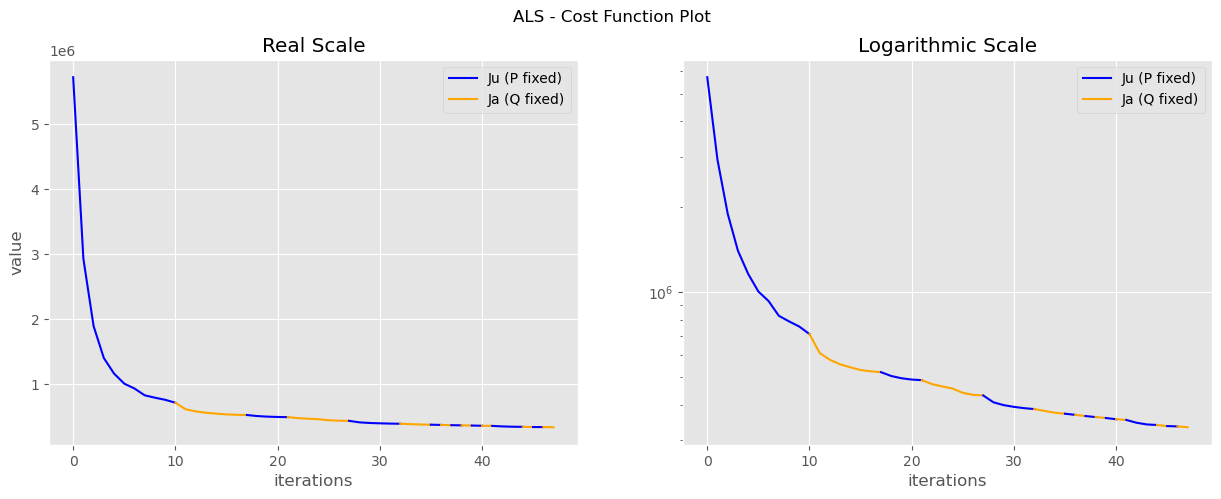

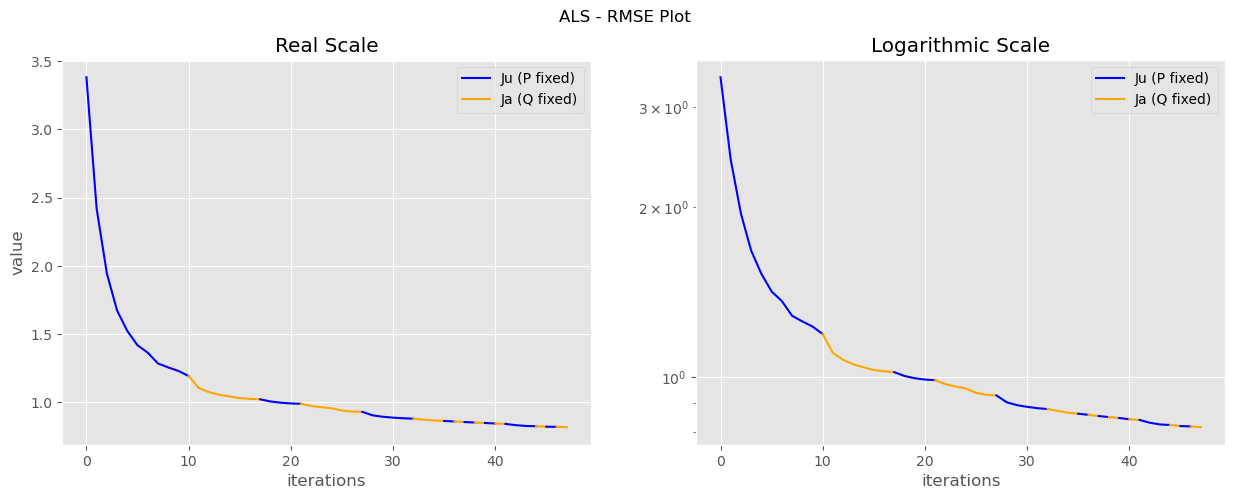

In [ ]:
plotALSResults(Ju_values, Ja_values, "ALS - Cost Function Plot")
plotALSResults(RMSEu_values, RMSEa_values, "ALS - RMSE Plot")


In [ ]:
mean = np.nanmean(R)
std = np.nanstd(R)
print(f"Global mean of matrix R: {mean}")
print(f" Global standard deviation of matrix R: {std}")
normR = (R - mean) / std

# Seed
np.random.seed(43)

f = 500
tol = 1e-5
max_iter = 1000

Jsim, DJsim = get_Jsim_and_DJsim(normR, f)

# Q and P initilization
Q = initializeQ(R.shape[0], f)
P = initializeP(R.shape[1], f)

Theta = np.concatenate((Q.flatten(), P.flatten()))

gradientDescentResults = gradientDescent(
    Jsim, Theta, DJsim, tol, max_iter, alpha0=0.0001
)
newThetas = gradientDescentResults["x_values"]
J_values = gradientDescentResults["func_values"]
newQs = gradientDescentResults["x_values"]

3.581564453029317
1.1171012869389085
Iteration    0: Cost 158128858.92   
Iteration  100: Cost 447661.16   
Iteration  200: Cost 174254.18   
Iteration  300: Cost 119615.38   
Iteration  400: Cost 98509.41   
Iteration  500: Cost 87149.00   
Iteration  600: Cost 79699.47   
Iteration  700: Cost 74205.43   
Iteration  800: Cost 69862.51   
Iteration  900: Cost 66281.07   
Iteration  999: Cost 63272.52   


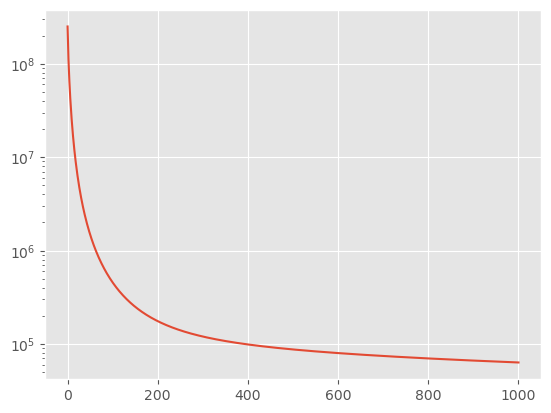

In [ ]:
plt.plot(J_values)
plt.yscale("log")

In [ ]:
m, n = R.shape
Q = newThetas[-1][: m * f].reshape(m, f)
P = newThetas[-1][m * f :].reshape(n, f)


In [ ]:
np.min((Q @ P.T) * std + mean)
np.mean((Q @ P.T) * std + mean)
np.std((Q @ P.T) * std + mean)


19.90407110920024

In [ ]:
mean


3.581564453029317

In [ ]:
np.nanmin(R)


1.0

In [ ]:
np.nanmax(R)


5.0

In [27]:
import numpy as np
from tqdm import tqdm

class CollaborativeFiltering:
    def __init__(self, num_users, num_items):
        self.num_users = num_users
        self.num_items = num_items
        self.user_embeddings = None
        self.item_embeddings = None

    def fit(self, interactions, num_factors=10, num_iterations=10, learning_rate=0.01):
        # Create user and item embeddings
        self.user_embeddings = np.random.normal(scale=1.0 / num_factors, size=(self.num_users, num_factors))
        self.item_embeddings = np.random.normal(scale=1.0 / num_factors, size=(self.num_items, num_factors))

        train_errors = []

        for iteration in tqdm(range(num_iterations), desc="Training Progress", position=0, leave=True):
            iteration_train_error = 0.0

            progress_bar = tqdm(total=len(interactions), desc=f"Iteration {iteration+1}/{num_iterations}, RMSE: ", position=0, leave=True)

            for user, item, rating in interactions:
                # Compute prediction error
                error = rating - self.predict(user, item)

                # Update user and item embeddings
                user_embedding = self.user_embeddings[user, :]
                item_embedding = self.item_embeddings[item, :]
                self.user_embeddings[user, :] += learning_rate * (error * item_embedding)
                self.item_embeddings[item, :] += learning_rate * (error * user_embedding)

                iteration_train_error += error ** 2
                progress_bar.update()

            iteration_train_rmse = np.sqrt(iteration_train_error / len(interactions))
            train_errors.append(iteration_train_rmse)

            progress_bar.set_description(f"Iteration {iteration+1}/{num_iterations}, RMSE: {iteration_train_rmse:.4f}")
            progress_bar.close()

        return train_errors

    def predict(self, user, item):
        # Compute the predicted rating for a user-item pair
        user_embedding = self.user_embeddings[user, :]
        item_embedding = self.item_embeddings[item, :]
        return np.dot(user_embedding, item_embedding)

    def recommend_items(self, user, top_k=5):
        # Recommend the top-k items for a given user
        user_embedding = self.user_embeddings[user, :]
        scores = np.dot(self.item_embeddings, user_embedding)
        top_item_indices = np.argsort(scores)[::-1][:top_k]
        return top_item_indices


In [58]:
model = CollaborativeFiltering(*R_train_val.shape)

In [46]:
import numpy as np

# Assuming your interaction matrix is represented as a NumPy array 'R'
num_users, num_movies = R.shape

# Create an empty list to store the tuples
tuples_list = []

# Iterate over the indices and values of the interaction matrix
for (user_id, movie_id), rating in np.ndenumerate(R):
    if not np.isnan(rating):  # Exclude entries with np.nan
        tuples_list.append((user_id, movie_id, rating))

print(len(tuples_list))

1000209


In [47]:
# Example usage of the interactions list
cf_model = CollaborativeFiltering(R.shape[0], R.shape[1])
errors = cf_model.fit(tuples_list, num_factors=10, num_iterations=10, learning_rate=0.001)

Training Progress: 100%|██████████| 10/10 [04:27<00:00, 26.73s/it]


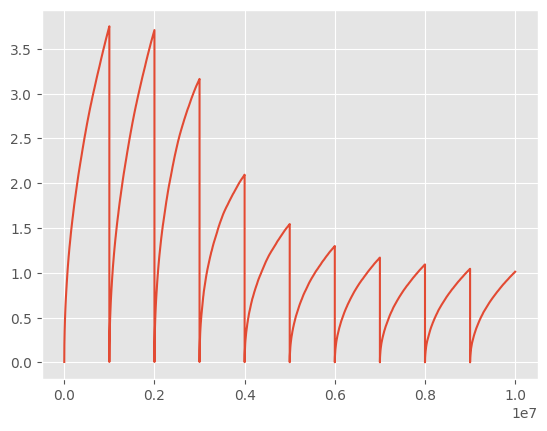

In [48]:
plt.plot(errors)